# Citations


@inproceedings{ulucan2020large,
title={A Large-Scale Dataset for Fish Segmentation and Classification},
author={Ulucan, Oguzhan and Karakaya, Diclehan and Turkan, Mehmet},
booktitle={2020 Innovations in Intelligent Systems and Applications Conference (ASYU)},
pages={1--5},
year={2020},
organization={IEEE}
}

O.Ulucan, D.Karakaya, and M.Turkan.(2020) A large-scale dataset for fish segmentation and classification.
In Conf. Innovations Intell. Syst. Appli. (ASYU)

# Necessary Modules

In [45]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import tensorflow as tf
from sklearn.metrics import classification_report
import seaborn as sns
from tensorflow.keras.applications import ResNet50
from sklearn.metrics import confusion_matrix
import warnings
from tensorflow.keras.optimizers.schedules import ExponentialDecay
warnings.filterwarnings('ignore')

# Listing image paths and labels

In [46]:
# Image settings
IMG_WIDTH, IMG_HEIGHT = 224, 224
IMG_SIZE = (IMG_WIDTH, IMG_HEIGHT)
INPUT_SHAPE = IMG_SIZE + (3,)

In [47]:
# Paths and labels
label = []
path = []
main_dir = '/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset'

# Gather image paths and labels
for dir_path, _, filenames in os.walk(main_dir):
    for filename in filenames:
        if os.path.splitext(filename)[-1] == '.png':
            if dir_path.split()[-1] != 'GT':
                label.append(os.path.split(dir_path)[-1])
                path.append(os.path.join(dir_path, filename))


# Visualizing Data

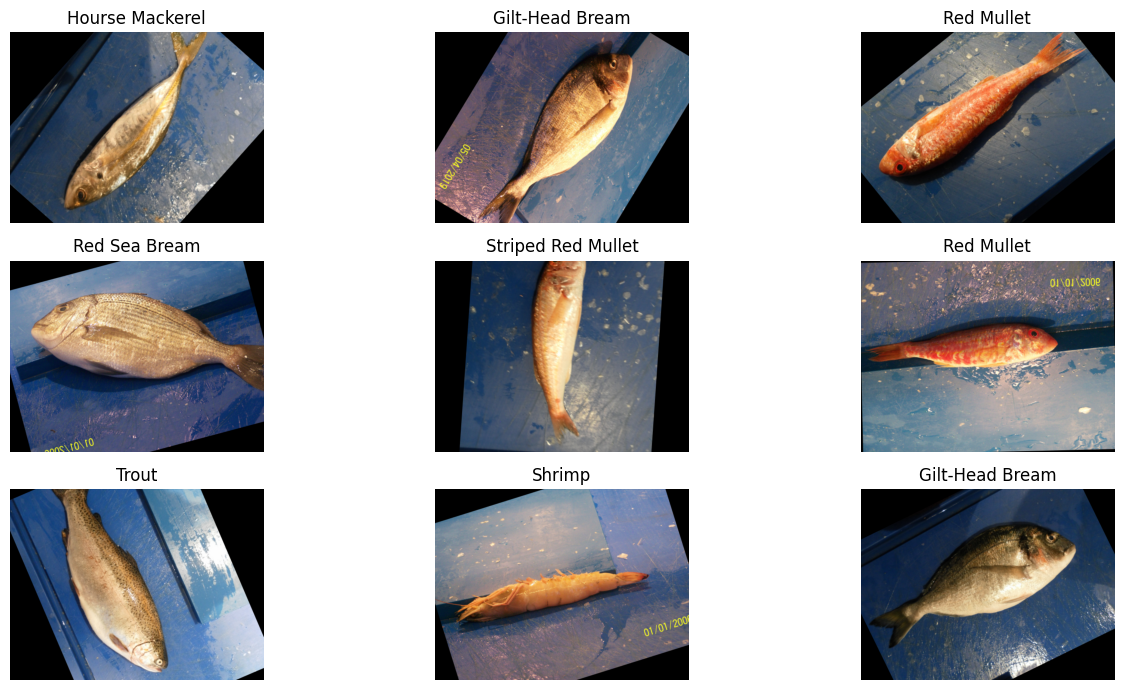

In [48]:
# Create dataframe for paths and labels
data = pd.DataFrame({'path': path, 'label': label})

# Visualize sample images
plt.figure(figsize=(14,7))
IMG_NUM = len(path)
for i in range(9):
    rand_num = np.random.randint(0, IMG_NUM)
    plt.subplot(3, 3, i+1)
    plt.title(label[rand_num])
    current_img = plt.imread(path[rand_num])
    plt.imshow(current_img)
    plt.axis('off')
plt.tight_layout()
plt.show()

# Splitting data as train, test and validation data

In [49]:
# Split the data into training, validation, and test sets
x_train, x_temp = train_test_split(data, test_size=0.2, random_state=42)
x_val, x_test = train_test_split(x_temp, test_size=0.8, random_state=42)

# Print data sizes
print(f"Length of x_train: {len(x_train)}")
print(f"Length of x_test: {len(x_test)}")
print(f"Length of x_val: {len(x_val)}")

Length of x_train: 7200
Length of x_test: 1440
Length of x_val: 360


# Importing preprocessing function and loading data

In [50]:
# Data augmentation and preprocessing
img_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

# Create data generators
x_train = img_datagen.flow_from_dataframe(
    dataframe=x_train,
    x_col ='path',
    y_col = 'label',
    class_mode='categorical',
    target_size = IMG_SIZE,
    seed=42
)
x_test = img_datagen.flow_from_dataframe(
    dataframe=x_test,
    x_col ='path',
    y_col = 'label',
    target_size = IMG_SIZE,
    seed=42,
    class_mode='categorical',
    shuffle=False
)
x_val = img_datagen.flow_from_dataframe(
    dataframe=x_val,
    x_col ='path',
    y_col = 'label',
    target_size = IMG_SIZE,
    class_mode='categorical',
    seed=42
)

Found 7200 validated image filenames belonging to 9 classes.
Found 1440 validated image filenames belonging to 9 classes.
Found 360 validated image filenames belonging to 9 classes.


# Importing Base Model Mixing it with our Model

In [51]:
# Load ResNet50 without top layers (Transfer learning)
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=INPUT_SHAPE)
base_model.trainable = False

# Create the model architecture
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(9, activation="softmax")  # Adjust for the number of classes
])

# Compiling Model

In [52]:
# Compile the model
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
    loss = "categorical_crossentropy",
    metrics=["accuracy"]
)

In [54]:
# Callbacks
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Train the model (initial training with frozen base model)
train = model.fit(
    x_train,
    epochs=10,
    validation_data=x_val,
    callbacks=[early_stop_callback, lr_scheduler]
)

Epoch 1/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 70s 303ms/step - accuracy: 0.4033 - loss: 1.5844 - val_accuracy: 0.5778 - val_loss: 1.2658 - learning_rate: 0.0010
Epoch 2/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 70s 301ms/step - accuracy: 0.4706 - loss: 1.4375 - val_accuracy: 0.5833 - val_loss: 1.1941 - learning_rate: 0.0010
Epoch 3/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 70s 301ms/step - accuracy: 0.5032 - loss: 1.3620 - val_accuracy: 0.6222 - val_loss: 1.1276 - learning_rate: 0.0010
Epoch 4/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 69s 298ms/step - accuracy: 0.5268 - loss: 1.3030 - val_accuracy: 0.6556 - val_loss: 1.1018 - learning_rate: 0.0010
Epoch 5/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 69s 297ms/step - accuracy: 0.5508 - loss: 1.2581 - val_accuracy: 0.6667 - val_loss: 0.9978 - learning_rate: 0.0010
Epoch 6/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 69s 298ms/step - accuracy: 0.5499 - loss: 1.2389 - val_accuracy: 0.6833 - val_loss: 0.9241 - learning_rate: 0.0010
Epoch 7/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 70s 301ms/step - accuracy: 0.5

# Fine-Tuning Our Model

## We unfreeze the ResNet50's layers and then freeze the last 20 layers.

In [55]:
# Fine-tuning: Unfreeze some layers of ResNet50 and continue training
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

lr_scheduler_compile = ExponentialDecay(
    initial_learning_rate=1e-5,
    decay_steps=10000,
    decay_rate=0.96,
    staircase=True
)

# Recompile with lower learning rate for fine-tuning
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_scheduler_compile),
    loss = "categorical_crossentropy",
    metrics=["accuracy"]
)

# Fine-tune the model
history_finetune = model.fit(
    x_train,
    epochs=20,
    validation_data=x_val,
    callbacks=[early_stop_callback, lr_scheduler]
)

Epoch 1/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 92s 324ms/step - accuracy: 0.3117 - loss: 11.7538 - val_accuracy: 0.3306 - val_loss: 3.5340 - learning_rate: 1.0000e-05
Epoch 2/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 69s 298ms/step - accuracy: 0.5613 - loss: 1.3323 - val_accuracy: 0.7028 - val_loss: 0.8522 - learning_rate: 1.0000e-05
Epoch 3/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 69s 296ms/step - accuracy: 0.6633 - loss: 0.9493 - val_accuracy: 0.8056 - val_loss: 0.6671 - learning_rate: 1.0000e-05
Epoch 4/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 68s 295ms/step - accuracy: 0.7165 - loss: 0.8002 - val_accuracy: 0.8167 - val_loss: 0.5545 - learning_rate: 1.0000e-05
Epoch 5/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 69s 297ms/step - accuracy: 0.7672 - loss: 0.6753 - val_accuracy: 0.8556 - val_loss: 0.4545 - learning_rate: 1.0000e-05
Epoch 6/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 69s 297ms/step - accuracy: 0.7874 - loss: 0.5943 - val_accuracy: 0.8694 - val_loss: 0.4087 - learning_rate: 1.0000e-05
Epoch 7/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 70s 3

# Plotting the Loss and Accuracy Curves

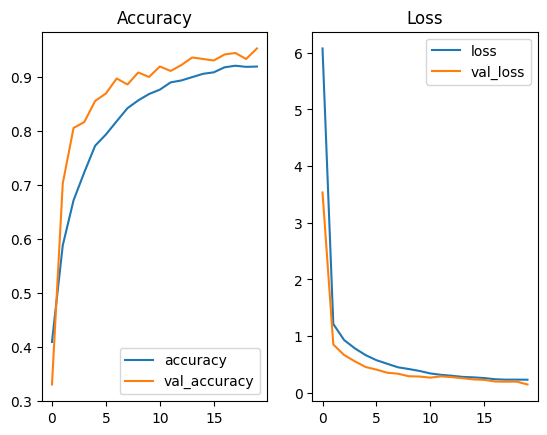

In [56]:
# Plot accuracy and loss
plt.subplot(1, 2, 1)
pd.DataFrame(history_finetune.history)[['accuracy', 'val_accuracy']].plot(ax=plt.gca())
plt.title("Accuracy")

plt.subplot(1, 2, 2)
pd.DataFrame(history_finetune.history)[['loss', 'val_loss']].plot(ax=plt.gca())
plt.title("Loss")
plt.show()

# Evaluating our Model

In [57]:
# Evaluate on test data
result = model.evaluate(x_test, verbose=0)
print("Test Loss:", result[0])
print("Test Accuracy:", result[1] * 100)

Test Loss: 0.15489965677261353
Test Accuracy: 94.9999988079071


In [58]:
# Predict on test data
preds = model.predict(x_test)
preds = np.argmax(preds, axis=1)


45/45 ━━━━━━━━━━━━━━━━━━━━ 17s 286ms/step


# Comparing Predictions vs True Labels


In [59]:
# Convert predicted labels
class_names = list(x_train.class_indices.keys())
#classes = dict((j, i) for i, j in classes.items())
pred_labels = [class_names[i] for i in preds]

# Classification report
y_test = list(x_test.labels)
print(classification_report(y_test, preds, target_names=class_names))

                    precision    recall  f1-score   support

   Black Sea Sprat       0.92      0.96      0.94       161
   Gilt-Head Bream       0.92      0.95      0.93       154
   Hourse Mackerel       0.97      0.93      0.95       166
        Red Mullet       0.98      0.98      0.98       148
     Red Sea Bream       0.97      0.93      0.95       166
          Sea Bass       0.96      0.95      0.95       167
            Shrimp       1.00      0.97      0.98       156
Striped Red Mullet       0.91      0.95      0.93       162
             Trout       0.94      0.94      0.94       160

          accuracy                           0.95      1440
         macro avg       0.95      0.95      0.95      1440
      weighted avg       0.95      0.95      0.95      1440



# Creating a Confuision Matrix

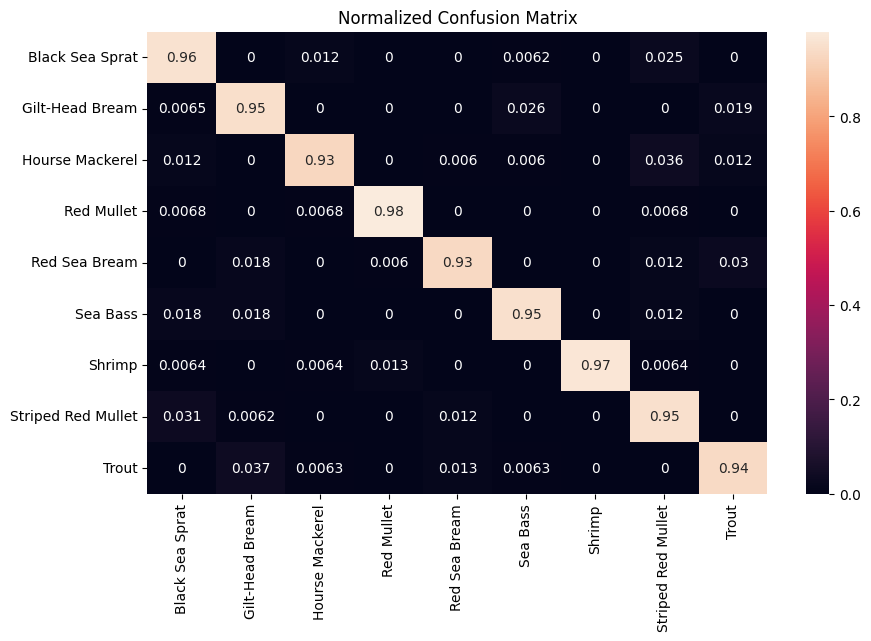

In [60]:
# Confusion matrix
cf_matrix = confusion_matrix(y_test, preds, normalize='true')
plt.figure(figsize=(10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels=class_names, yticklabels=class_names)
plt.title('Normalized Confusion Matrix')
plt.show()


# Plotting Predictions and their Labels

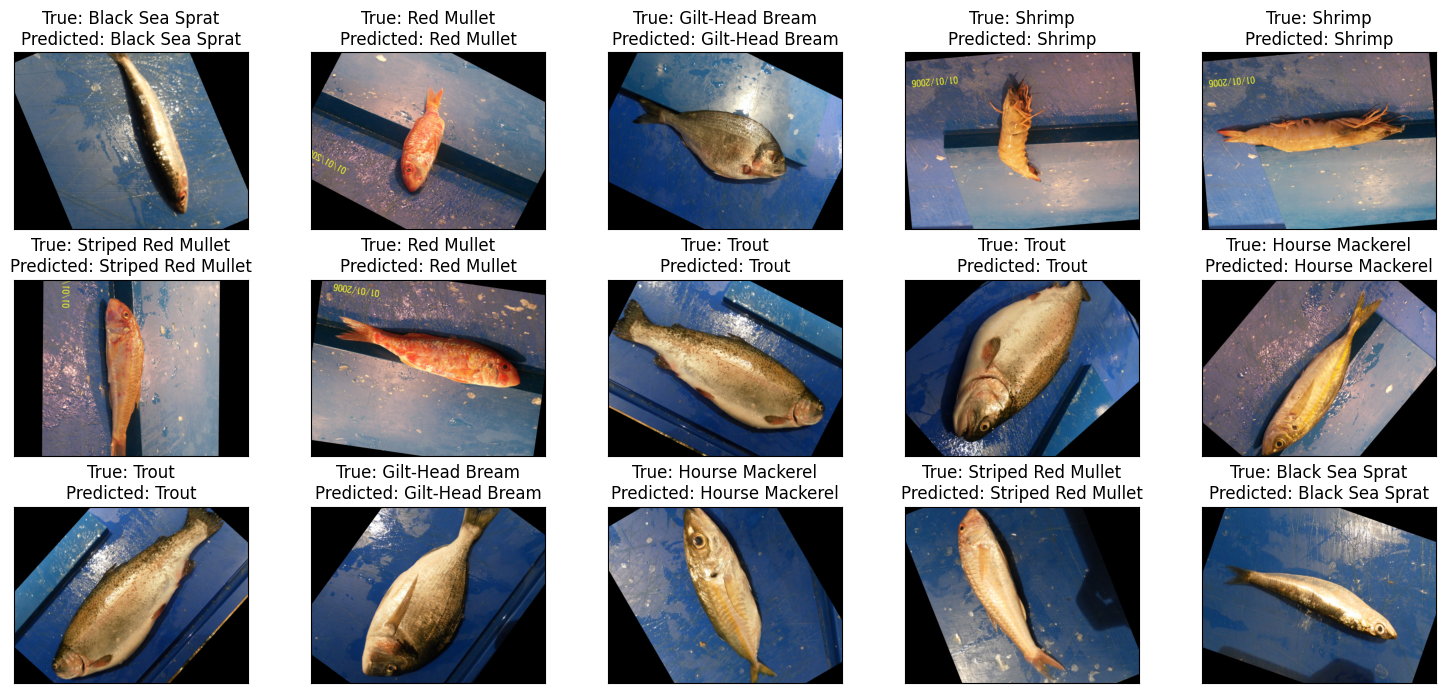

In [61]:
# Display sample predictions
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7), subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(x_test.filepaths[i]))
    ax.set_title(f"True: {class_names[x_test.labels[i]]}\nPredicted: {pred_labels[i]}")
plt.tight_layout()
plt.show()